In [1]:
from scipy.io import netcdf
import numpy
import netCDF4
import pandas
import aacgmv2
import xarray
import feather
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.dates import date2num, DateFormatter, MinuteLocator
from matplotlib.ticker import FuncFormatter, MaxNLocator
from davitpy import utils
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ampFName = "../data/20110608.0000.86400.120.north.grd.ncdf"
startDate = datetime.datetime( 2011, 6, 8, 4, 0 )
selDate = datetime.datetime( 2011, 6, 8, 4, 30 )
endDate = datetime.datetime( 2011, 6, 8, 7, 0 )
delTime = datetime.timedelta(minutes=2)
coords = "mlt"
plotMlatRange = [ 55., 70. ]
# Max latitude at which you expect 
# to find downward FACs associated with SCW
cutOffDownSCWMlat = 55. 

In [3]:
dsXarr = xarray.open_dataset(ampFName)
ampDF = dsXarr.to_dataframe()
ampDF["start_date"] = pandas.to_datetime( dict(year=ampDF.start_yr,\
                    month=ampDF.start_mo, day=ampDF.start_dy,\
                    hour=ampDF.start_hr, minute=ampDF.start_mt,\
                    second=ampDF.start_sc))
ampDF["end_date"] = pandas.to_datetime( dict(year=ampDF.end_yr,\
                    month=ampDF.end_mo, day=ampDF.end_dy,\
                    hour=ampDF.end_hr, minute=ampDF.end_mt,\
                    second=ampDF.end_sc))
ampDF["mlat"] = 90. - ampDF["colat"]
selCols = ['start_date', 'end_date', 'mlat',\
           'mlt', 'dBnorth1', 'dBeast1',\
       'dBnorth2', 'dBeast2', 'dBr', 'Jr']
ampDF = ampDF[selCols].reset_index(drop=True)

ampDF.head()

,start_date,end_date,mlat,mlt,dBnorth1,dBeast1,dBnorth2,dBeast2,dBr,Jr
0,2011-06-08,2011-06-08 00:10:00,89.0,0.0,147.089996,30.629999,143.679993,43.900002,29.889999,-0.02
1,2011-06-08,2011-06-08 00:10:00,88.0,0.0,159.339996,31.719999,154.250000,51.009998,24.180000,-0.09
2,2011-06-08,2011-06-08 00:10:00,87.0,0.0,158.559998,25.010000,153.210007,47.889999,4.960000,-0.13
3,2011-06-08,2011-06-08 00:10:00,86.0,0.0,140.130005,15.470000,135.770004,37.970001,-23.920000,-0.13
4,2011-06-08,2011-06-08 00:10:00,85.0,0.0,111.970001,5.390000,109.360001,24.600000,-53.520000,-0.12


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


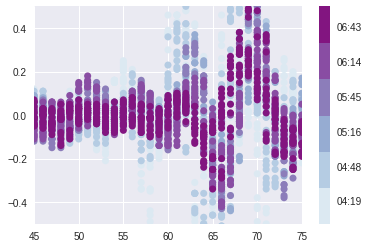

In [4]:
seaMap = ListedColormap(sns.color_palette("BuPu"))
selMlt = 22.

fig = plt.figure()
ax = fig.add_subplot(111)

selDF = ampDF[ ((ampDF["start_date"] >= startDate) & (ampDF["start_date"] <= endDate) &\
                    (ampDF["mlt"] == selMlt) & (numpy.abs(ampDF["Jr"])>=0.)) ]
selDF["time"] = [ date2num(x) for x in selDF["start_date"] ]#selDF["start_date"].map(lambda x:(x.hour + x.minute/60.)*100)
smap = ax.scatter(selDF['mlat'],selDF['Jr'],s=50,c=selDF['time'],
                  edgecolors='none', marker='o', cmap=seaMap) 
ax.set_xlim( [45, 75] )
ax.set_ylim( [-0.5, 0.5] )
cb = fig.colorbar(smap, orientation='vertical')
# ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))
cb.formatter = DateFormatter('%H:%M')
cb.update_ticks()
# cb.ax.set_yticklabels(set([ x.strftime('%H:%M') for x in selDF['start_date'] ]))
fig.savefig( "../plots/mltAmpTime-20110608.pdf",bbox_inches='tight' )

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


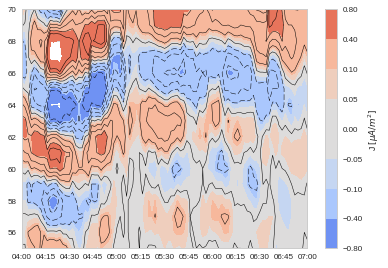

In [10]:
# Some temp constants
plotMltChsn = 22
plotJrCutoff = 0.0
plotJrMin = -0.4
plotJrMax = 0.4
ticks = [ -0.8, -0.4, -0.1, -0.05, 0, 0.05, 0.1, 0.4, 0.8 ]
# set a few standard xticks
xTickList = []
currTime = startDate
while currTime <= endDate:
    xTickList.append( currTime )
    currTime += datetime.timedelta(minutes=15)
# Plotting
seaMap = ListedColormap(sns.color_palette("coolwarm",11))

sns.set_style("whitegrid")
sns.set_context("paper")

fig = plt.figure()
ax = fig.add_subplot(111)
selDF = ampDF[ ((ampDF["start_date"] >= startDate) & (ampDF["start_date"] <= endDate) &\
                    (ampDF["mlt"] == plotMltChsn) & (numpy.abs(ampDF["Jr"])>=plotJrCutoff) &\
              (ampDF["mlat"] >= plotMlatRange[0]) & (ampDF["mlat"] <= plotMlatRange[1]) )]
selDF["time"] = [ date2num(x) for x in selDF["start_date"] ]
plotAmpDF = selDF[ ["mlat", "time",\
                        "Jr"] ].pivot( "mlat", "time" )
mlatVals = plotAmpDF.index.values
timeVals = plotAmpDF.columns.levels[1].values
mlatCntr, timeCntr  = numpy.meshgrid( mlatVals, timeVals )
jrVals = numpy.ma.masked_where(numpy.isnan(plotAmpDF["Jr"].values),plotAmpDF["Jr"].values)
ampPlot = ax.contourf(timeCntr, mlatCntr,jrVals.T, ticks,cmap=seaMap)
ax.contour(timeCntr, mlatCntr,jrVals.T, numpy.linspace(-0.5, 0.5, 9),
                 origin='lower',
                 linewidths=0.5,colors='k')
cbar = plt.colorbar(ampPlot)
cbar.set_label(r"J $ [\mu A/m^{2}]$")

ax.set_xticks(xTickList)

ax.get_xaxis().set_major_formatter(DateFormatter('%H:%M'))

# Plot SD data

fig.savefig( "../plots/scw-20110608.pdf",bbox_inches='tight' )